In [1]:
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
cudnn.benchmark = True
plt.ion()   # interactive m
from datetime import datetime
now = datetime.now
T0 = now()

from IPython import display
import sys

In [2]:
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
#from torchvision.models import resnet50, ResNet50_Weights


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
torch.cuda.get_device_name(0)

'Tesla V100-SXM2-16GB'

In [5]:
class HAA_dataset(Dataset):
    "Video frame Dataset"
    def __init__(self,data_dir,usage='train'):
        self.data_dir = data_dir
        self.categories = os.listdir(self.data_dir)
        self.categories.sort()
        self.n_cat = len(self.categories)
        self.usage = usage
        
        ## To make test and val, deterministic
        ## Works on images
        ## doest seem to affect transforms
        if self.usage=='train':
            seed = np.random.randint(2147483647) 
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        else:
            seed = 42
            random.seed(seed) 
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        frames = []
        for category in self.categories:
            folder_frames = [frame for frame in os.listdir(os.path.join(data_dir,category)) if not frame.startswith('.')]
            folder_frames.sort()
            frames.append(folder_frames)
        self.frames = frames
        
        self.Ts = transforms.Compose([transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3, hue=.3),
        transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 2.0))])
        
    def __len__(self):
        return 10_000 # 
        
    def __getitem__(self, idx):
        
        self.rand_cat = np.random.randint(low=0,high=self.n_cat)
        self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        im = Ts(im)
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        #sample = {'image': torch.from_numpy(image).float(), 'label': torch.from_numpy(label).float()}  # make a dict with the image and the correct label
        sample = {'image': torch.from_numpy(im).float(), 'label': torch.from_numpy(np.array([self.rand_cat])).float()}  # make a dict with the image and the correct label
        return sample
    
    
    def get_im(self,rand_cat,frame_idx=None):
        self.rand_cat = rand_cat
        
        if type(frame_idx)==type(None): # For training, randomly choose image
            self.rand_frame = np.random.randint(low=0,high=len(self.frames[self.rand_cat]))
        else: # For val and test, deterministic 
            self.rand_frame = np.mod(frame_idx,len(self.frames[self.rand_cat])) # a spell that loops over array infinitely
            
        fn = os.path.join(self.data_dir,self.categories[self.rand_cat],self.frames[self.rand_cat][self.rand_frame])
        im = Image.open(fn)
        
        if self.usage=='train': # if training, add transforms for data augmentation
            im = self.Ts(im)
            
        im = np.array(im)
        im = im/255
        im = im.swapaxes(2,1).swapaxes(0,1)
        
        return im
    
    def get_batch(self,batch_size):
        self.this_batch_cats = np.random.randint(low=0,high=self.n_cat,size=batch_size)
        self.this_batch_cats = np.array(self.this_batch_cats)
        self.this_batch_im = [self.get_im(i) for i in self.this_batch_cats]
        self.this_batch_im = np.array(self.this_batch_im)
        sample = {'image': torch.from_numpy(self.this_batch_im).float(), 'label': torch.from_numpy(self.this_batch_cats).float()}  # make a dict with the image and the correct label
        return sample

In [6]:
def show_dahsboard():
    
    plt.close();
    sys.stdout.flush();
    display.clear_output(wait=True);
    display.display(plt.gcf());

    nrows = 3;
    ncols = 2;
    plt.figure(figsize=(5*nrows,5*ncols));
    i = 0;

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(loss_memory);
    plt.title('training loss');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(train_acc);
    plt.title('training acc');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_memory);
    plt.title('validation loss');

    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_acc);
    plt.title('validation acc');
    
    i=i+1;plt.subplot(nrows,ncols,i);
    #plt.plot(val_acc);
    #plt.title('validation acc');
    
    i=i+1;plt.subplot(nrows,ncols,i);
    plt.plot(val_acc5);
    plt.title('validation top5 acc');
    
    
    
    plt.suptitle(f'epoch [{epoch}] runtime: {now()-T0}   T: {now()}',y=1.05,fontsize=15);
    plt.tight_layout();
    plt.show();

In [7]:
def get_acc(which_dataset,topk=1):
    net.eval();
    
    ncat = 45
    nrep = 10
    test_res = np.zeros((nrep,ncat))
    
    for c in range(ncat):
        for rep in range(nrep):
            test_im = torch.from_numpy(which_dataset.get_im(c)[np.newaxis,:,:,:]).half().cuda()
            test_pred = net(test_im)
            test_pred = np.array(test_pred.cpu().detach().numpy())[0,:]
            #test_res[rep,c] = np.argmax(test_pred)==c
            test_res[rep,c] = c in np.argsort(test_pred)[-topk::]
        
    return test_res.mean(axis=0).mean()

In [8]:
data_dir = './Data/pytorch-data/action_data_orig/train'
train_dataset = HAA_dataset(data_dir,usage='train')

In [9]:
val_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/val',usage='val')
test_dataset = HAA_dataset('./Data/pytorch-data/action_data_orig/test',usage='test')

In [10]:
net = resnet50()
net.fc = nn.Linear(net.fc.in_features,train_dataset.n_cat)

net = net.to(device)
net.half();

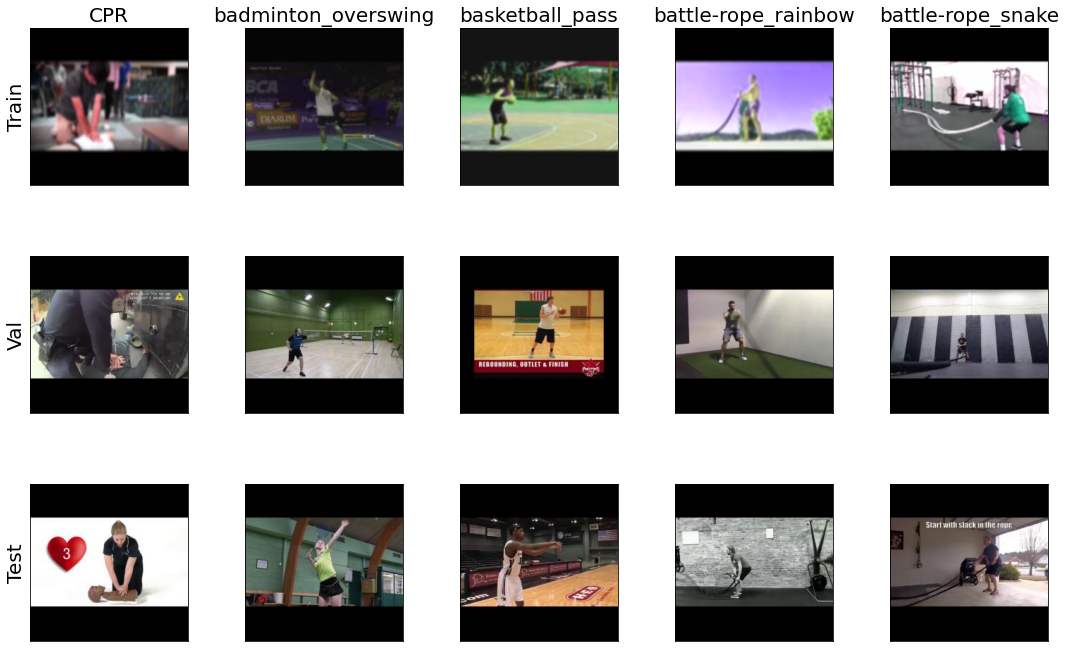

In [11]:
plt.figure(figsize=(15,10))
choose_cats = np.arange(5)

for i in range(5):
    plt.subplot(3,5,i+1)
    plt.imshow(train_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    plt.title(train_dataset.categories[choose_cats[i]],fontsize=20)
    if i==0:
        plt.ylabel('Train',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+5)
    plt.imshow(val_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Val',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
for i in range(5):
    plt.subplot(3,5,i+1+10)
    plt.imshow(test_dataset.get_im(choose_cats[i]).swapaxes(0,1).swapaxes(1,2))
    #plt.axis('off')
    if i==0:
        plt.ylabel('Test',fontsize=20)
    plt.xticks([]);plt.yticks([])
    
plt.tight_layout()

In [12]:
criterion = nn.CrossEntropyLoss()                                 # specify the loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)     # specify the optimizer

In [13]:
#val_data = val_dataset.get_batch(64)
val_data = val_dataset.get_batch(128)
val_images = val_data['image'].half()
val_labels = val_data['label'].half()
tmp = []
val_labels = torch.squeeze(val_labels.long())
#val_images, val_labels = val_images.cuda(),  val_labels.cuda()

In [14]:
#print(f'epoch [{epoch}], train loss {epoch_loss:.2f}, ValLoss [{val_loss:.2f}], ValAcc [{val_acc[-1]:.4f}], TrainAcc [{train_acc[-1]:.4f}], T: {now()}')

In [15]:
save_freq = 5                               # specify every how many epochs to save the model
loss_memory = []
val_memory = []
val_acc = []
val_acc5 = []
train_acc = []

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

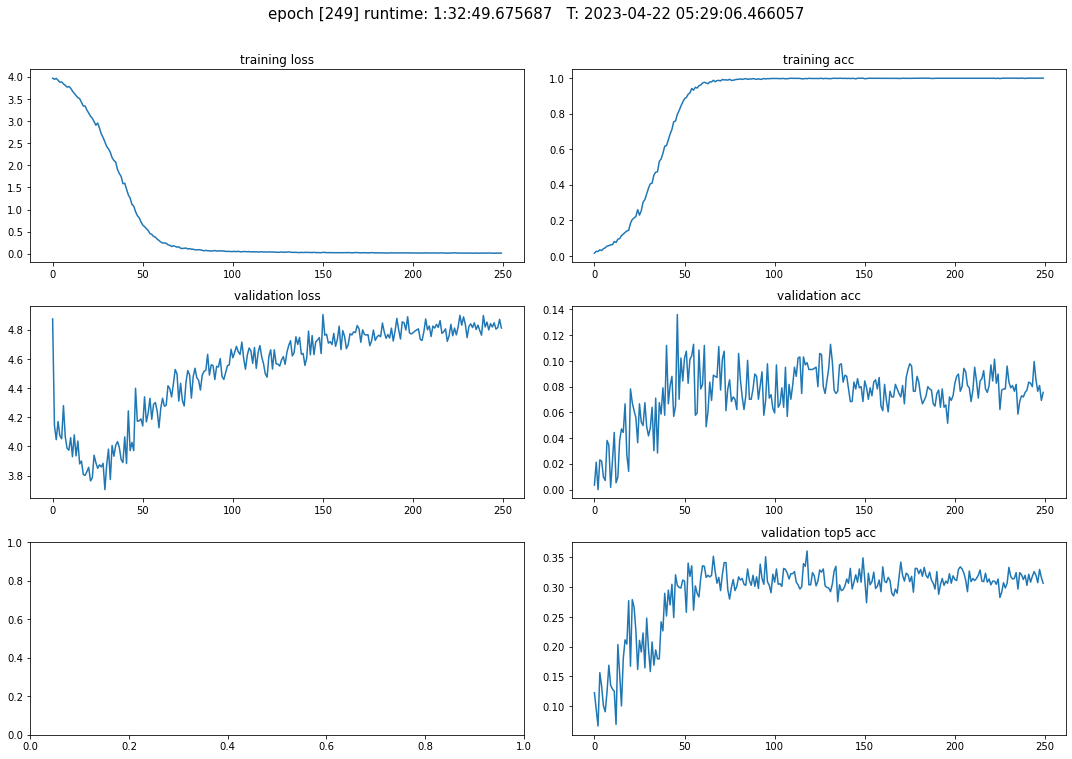

In [16]:
n_batches = 50
for epoch in range(250):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0
    net.train()
    for _ in range(n_batches):
        #torch.cuda.empty_cache() 
        # get the inputs
        data = train_dataset.get_batch(32)
        images = data['image'].half()
        labels = data['label'].half()
        tmp = []
        tmp = torch.squeeze(labels.long())
        images, labels = images.cuda(),  tmp.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        
        running_loss += loss.data.item()
        running_acc += np.array([outputs.detach().cpu().numpy()[jj,:].argmax()==labels.detach().cpu().numpy()[jj] for jj in range(outputs.shape[0])]).mean()
    epoch_loss = running_loss / n_batches
    epoch_acc = running_acc / n_batches
    loss_memory.append(epoch_loss)
    running_loss = 0.0
    
    ## Stuff for Dashboard
    net.eval();
    val_loss = 0
    temp_top1 = 0
    temp_top5 = 0

    for kk in range(25):
        val_images_cuda = torch.tensor(np.array([val_dataset.get_im(i,kk) for i in range(45)])).half().cuda()
        val_labels_cuda = torch.tensor(np.arange(45)).long().cuda()
        val_outputs = net(val_images_cuda)
        val_loss += criterion(val_outputs, val_labels_cuda).data.item()
        val_outputs = val_outputs.detach().cpu().numpy()
        temp_top1 += np.array([jj==val_outputs[jj,:].argsort()[-1] for jj in range(45)]).mean()
        temp_top5 += np.array([jj in val_outputs[jj,:].argsort()[-5::] for jj in range(45)]).mean()

    val_loss = val_loss/(kk+1)
    temp_top1 = temp_top1/(kk+1)
    temp_top5 = temp_top5/(kk+1)
    
    # keep trakc of values for plotting
    val_memory.append( val_loss ) 
    val_acc.append( temp_top1 )
    val_acc5.append( temp_top5 )
    train_acc.append( epoch_acc )
    
    show_dahsboard()
    
torch.save(net.state_dict(), './Data/pytorch-data/weights/weights')
np.save('./Data/pytorch-data/weights/loss_memory.npy',loss_memory)
np.save('./Data/pytorch-data/weights/val_memory.npy',val_memory)
np.save('./Data/pytorch-data/weights/val_acc.npy',val_acc)
np.save('./Data/pytorch-data/weights/val_acc5.npy',val_acc5)
np.save('./Data/pytorch-data/weights/train_acc.npy',train_acc)
#print(f'epoch [{epoch}], train loss {epoch_loss:.2f}, ValLoss [{val_loss:.2f}], ValAcc [{val_acc[-1]:.4f}], TrainAcc [{train_acc[-1]:.4f}]T: {now()')    

In [107]:
test_top1 = []
test_top5 = []
confusion_matrix = np.zeros((45,45))

for c in tqdm(range(45)):
    temp = []
    for f in range(len(test_dataset.frames[c])):
        im = torch.tensor(test_dataset.get_im(c,f)[np.newaxis,:,:,:]).half().cuda()
        pred = net(im)
        pred = pred.detach().cpu().numpy()[0]
        confusion_matrix[c,pred.argmax()]+=1

        test_top1.append( c==pred.argsort()[-1] )
        test_top5.append( c in pred.argsort()[-5::] )
        
test_top1 = np.array(test_top1)
test_top5 = np.array(test_top5)

100%|██████████| 45/45 [00:15<00:00,  2.89it/s]


In [122]:
test_top1.mean()

0.15106007067137808

In [123]:
test_top5.mean()

0.30697879858657245

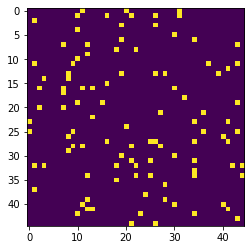

In [124]:
plt.imshow(confusion_matrix,vmin=0,vmax=1)

In [111]:
confusion_matrix.min()

0.0

In [112]:
confusion_matrix[1,1]

0.0

In [61]:
#   val_images_cuda = torch.tensor(np.array([val_dataset.get_im(i,kk) for i in range(45)])).half().cuda()
#         val_labels_cuda = torch.tensor(np.arange(45)).long().cuda()
#         val_outputs = net(val_images_cuda)
#         val_loss += criterion(val_outputs, val_labels_cuda).data.item()
#         val_outputs = val_outputs.detach().cpu().numpy()
#         temp_top1 += np.array([jj==val_outputs[jj,:].argsort()[-1] for jj in range(45)]).mean()
#         temp_top5 += np.array([jj in val_outputs[jj,:].argsort()[-5::] for jj in range(45)]).mean()

In [54]:
# print(get_acc(test_dataset,topk=1))
# print(get_acc(test_dataset,topk=5))

In [28]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg'

In [34]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [42]:
def norm(vec):
    vec = np.array(vec)
    return(vec - vec.min()) / (vec.max()-vec.min())

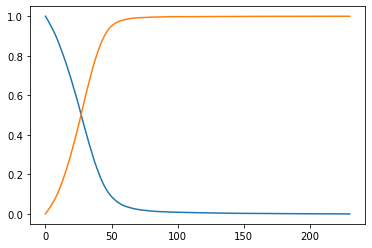

In [53]:
k = 20
plt.plot(norm(moving_average(loss_memory,k)))
plt.plot(norm(moving_average(train_acc,k)))

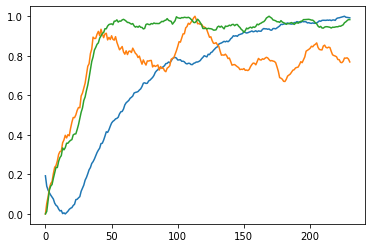

In [50]:
#plt.plot(norm(val_memory))
k = 20
plt.plot(norm(moving_average(val_memory,k)))
plt.plot(norm(moving_average(val_acc,k)))
plt.plot(norm(moving_average(val_acc5,k)))

In [18]:
#     net.eval();
#     torch.cuda.empty_cache()
#     del images # Space saving wizardry
#     del labels # Space saving wizardry
#     val_images_cuda, val_labels_cuda = val_images.cuda(),  val_labels.cuda() # Space saving wizardry, convert to CUDA on demand
#     val_outputs = net(val_images_cuda)
#     val_loss = criterion(val_outputs, val_labels_cuda)
#     del val_images_cuda # Space saving wizardry
#     del val_labels_cuda # Space saving wizardry

#     val_memory.append(val_loss.data.item()) 
#     val_acc.append( get_acc(val_dataset) )
#     val_acc5.append( get_acc(val_dataset,topk=5) )
#     train_acc.append( get_acc(train_dataset) )

In [19]:
# net.eval();
# torch.cuda.empty_cache()
# #del images # Space saving wizardry
# #del labels # Space saving wizardry
# val_images_cuda, val_labels_cuda = val_images.cuda(),  val_labels.cuda() # Space saving wizardry, convert to CUDA on demand
# val_outputs = net(val_images_cuda)
# val_loss = criterion(val_outputs, val_labels_cuda)
# del val_images_cuda # Space saving wizardry
# del val_labels_cuda # Space saving wizardry
# val_memory.append(val_loss.data.item())

# val_acc.append( get_acc(val_dataset) )
# val_acc5.append( get_acc(val_dataset,topk=5) )
# train_acc.append( get_acc(train_dataset) )

In [20]:
#plt.imshow(np.array([val_dataset.get_im(i,1) for i in range(45)])[2,:,:,:].swapaxes(0,1).swapaxes(1,2))

In [21]:
# #val_data = val_dataset.get_batch(64)
# val_data = val_dataset.get_batch(128)
# val_images = val_data['image'].half()
# val_labels = val_data['label'].half()
# tmp = []
# val_labels = torch.squeeze(val_labels.long())
# #val_images, val_labels = val_images.cuda(),  val_labels.cuda()

In [22]:
#torch.tensor(np.arange(45)).long().cuda()

In [23]:
#val_labels

In [24]:
#val_labels.long?